In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [6]:
! kaggle datasets download -d "minatverma/nse-stocks-data"

Dataset URL: https://www.kaggle.com/datasets/minatverma/nse-stocks-data
License(s): CC0-1.0
 67% 20.0M/29.9M [00:00<00:00, 203MB/s]
100% 29.9M/29.9M [00:00<00:00, 140MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/nse-stocks-data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
stock_df = pd.read_csv('/content/FINAL_FROM_DF.csv')

In [9]:
stock_df.head()

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES,ISIN
0,20MICRONS,EQ,37.80,37.80,36.15,36.85,37.40,37.05,27130,994657.90,2017-06-28,202,INE144J01027
1,3IINFOTECH,EQ,4.10,4.85,4.00,4.55,4.65,4.05,20157058,92148517.65,2017-06-28,7353,INE748C01020
2,3MINDIA,EQ,13425.15,13469.55,12920.00,13266.70,13300.00,13460.55,2290,30304923.35,2017-06-28,748,INE470A01017
3,63MOONS,EQ,61.00,61.90,60.35,61.00,61.10,60.65,27701,1689421.00,2017-06-28,437,INE111B01023
4,8KMILES,EQ,546.10,548.00,535.00,537.45,535.20,547.45,79722,43208620.05,2017-06-28,1866,INE650K01021


In [10]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846404 entries, 0 to 846403
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   SYMBOL       846404 non-null  object 
 1   SERIES       843947 non-null  object 
 2   OPEN         846404 non-null  float64
 3   HIGH         846404 non-null  float64
 4   LOW          846404 non-null  float64
 5   CLOSE        846404 non-null  float64
 6   LAST         846404 non-null  float64
 7   PREVCLOSE    846404 non-null  float64
 8   TOTTRDQTY    846404 non-null  int64  
 9   TOTTRDVAL    846404 non-null  float64
 10  TIMESTAMP    846404 non-null  object 
 11  TOTALTRADES  846404 non-null  int64  
 12  ISIN         846404 non-null  object 
dtypes: float64(7), int64(2), object(4)
memory usage: 83.9+ MB


In [11]:
company_df = stock_df[(stock_df['SYMBOL'] == 'ICICIBANK') & (stock_df['SERIES'] == 'EQ')]

In [12]:
company_df

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES,ISIN
616,ICICIBANK,EQ,288.75,293.30,288.75,290.35,289.95,287.90,17157094,4.992441e+09,2017-06-28,94651,INE090A01021
2392,ICICIBANK,EQ,313.10,315.35,311.75,313.20,313.00,317.00,13929413,4.370816e+09,2017-11-28,86488,INE090A01021
4184,ICICIBANK,EQ,278.95,280.10,275.70,276.35,276.70,278.85,16527127,4.578699e+09,2017-02-28,98978,INE090A01021
5911,ICICIBANK,EQ,273.50,279.40,272.90,278.50,277.90,274.15,8515909,2.359974e+09,2017-04-28,69228,INE090A01021
7665,ICICIBANK,EQ,279.70,279.70,274.00,275.05,275.20,280.60,11048388,3.038922e+09,2017-03-20,101834,INE090A01021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
838562,ICICIBANK,EQ,255.20,261.20,252.80,257.65,257.25,254.10,22853993,5.883213e+09,2016-06-08,225541,INE090A01021
840198,ICICIBANK,EQ,222.80,224.85,220.50,221.35,221.05,221.65,12250507,2.721565e+09,2016-03-15,87315,INE090A01021
841816,ICICIBANK,EQ,220.55,223.80,219.55,221.25,221.50,220.30,9078974,2.012991e+09,2016-04-08,60882,INE090A01021
843469,ICICIBANK,EQ,275.80,275.85,269.90,271.25,271.15,275.50,16343247,4.458892e+09,2016-09-23,84233,INE090A01021


In [13]:
# Filter relevant columns and sort by date
company_df = company_df[[ 'TIMESTAMP', 'OPEN', 'HIGH', 'LOW', 'CLOSE','PREVCLOSE']]
company_df['TIMESTAMP'] = pd.to_datetime(company_df['TIMESTAMP'])
company_df = company_df.sort_values(by='TIMESTAMP')

<ipython-input-13-2f0d3f665f84>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df['TIMESTAMP'] = pd.to_datetime(company_df['TIMESTAMP'])


In [14]:
company_df.isnull().sum()

,0
TIMESTAMP,0
OPEN,0
HIGH,0
LOW,0
CLOSE,0
PREVCLOSE,0


In [15]:
company_df.corr()

,TIMESTAMP,OPEN,HIGH,LOW,CLOSE,PREVCLOSE
TIMESTAMP,1.000000,0.876718,0.874011,0.877273,0.875801,0.873226
OPEN,0.876718,1.000000,0.994149,0.995138,0.990318,0.993755
HIGH,0.874011,0.994149,1.000000,0.992867,0.996927,0.989047
LOW,0.877273,0.995138,0.992867,1.000000,0.994070,0.989104
CLOSE,0.875801,0.990318,0.996927,0.994070,1.000000,0.984978
PREVCLOSE,0.873226,0.993755,0.989047,0.989104,0.984978,1.000000


<Axes: >

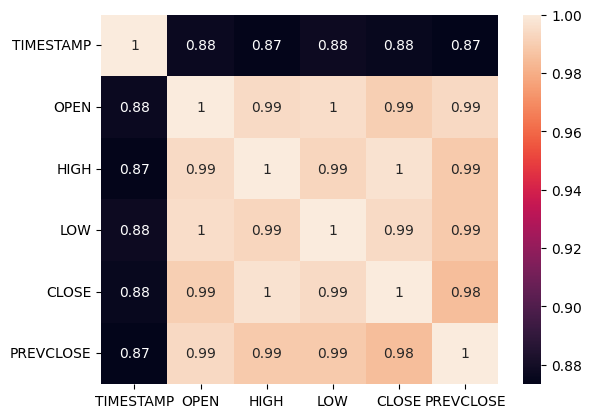

In [16]:
sns.heatmap(company_df.corr(), annot=True)

In [17]:
# Separate features and target
features = company_df[['OPEN', 'HIGH', 'LOW', 'CLOSE','PREVCLOSE']].values

# Split the data into training and test sets (80-20 split)
train_size = int(len(features) * 0.8)
train_data, test_data = features[:train_size], features[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


# Prepare the data for LSTM
def create_sequences(data, time_steps=60):
    X = []
    y = []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])  # Use all features as input
        y.append(data[i, 3])  # 'CLOSE' column is the target variable # This line now accesses the correct 'CLOSE' column
    return np.array(X), np.array(y)

# Create sequences for LSTM model
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

In [19]:
from tensorflow.keras.initializers import HeNormal  # Import HeNormal


In [20]:
X_train.shape[1]

60

In [21]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]),
               kernel_initializer='he_normal'))

model.add(Dropout(0.3))
model.add(Dense(units=1))



# # Second LSTM layer with BatchNormalization and Dropout
# model.add(LSTM(units=30, return_sequences=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())  # Batch Normalization
# model.add(Dropout(0.4))  # Dropout

# Output layer (predict the closing price)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test),verbose=1)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.2831 - val_loss: 0.1020
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1448 - val_loss: 0.0272
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1265 - val_loss: 0.0093
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1153 - val_loss: 0.0028
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0800 - val_loss: 0.0016
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0429 - val_loss: 0.0014
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0415 - val_loss: 0.0015
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0402 - val_loss: 0.0014
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0242 - val_loss: 0.0013
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0256 - val_loss: 0.0079
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0209 - val_loss: 0.0013
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

In [24]:
# Make predictions
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step


In [25]:

# Inverse transform the predictions and actual values to get actual stock prices
y_pred = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], X_train.shape[2] - 1)), y_pred), axis=1))[:, -1]
y_test_scaled = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], X_train.shape[2] - 1)), y_test.reshape(-1, 1)), axis=1))[:, -1]

In [26]:
y_train_pred = model.predict(X_train)
y_train_pred = scaler.inverse_transform(np.concatenate((np.zeros((y_train_pred.shape[0], X_train.shape[2] - 1)), y_train_pred), axis=1))[:, -1]
y_train_scaled = scaler.inverse_transform(np.concatenate((np.zeros((y_train.shape[0], X_train.shape[2] - 1)), y_train.reshape(-1, 1)), axis=1))[:, -1]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [27]:
# Metrics for training data
mse_train = mean_squared_error(y_train_scaled, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_scaled, y_train_pred)
r2_train = r2_score(y_train_scaled, y_train_pred)

In [28]:
# Print the results
print("Training Results:")
print("MSE:", mse_train)
print("RMSE:", rmse_train)
print("MAE:", mae_train)
print("R² Score:", r2_train)

Training Results:
MSE: 28.883754654744084
RMSE: 5.374360860115748
MAE: 3.8801085124923187
R² Score: 0.9521718175858614


In [29]:
# Metrics for test data
mse_test = mean_squared_error(y_test_scaled, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_scaled, y_pred)
r2_test = r2_score(y_test_scaled, y_pred)

In [30]:
print("\nTest Results:")
print("MSE:", mse_test)
print("RMSE:", rmse_test)
print("MAE:", mae_test)
print("R² Score:", r2_test)


Test Results:
MSE: 17.017493485759108
RMSE: 4.125226476905129
MAE: 3.3991317898799287
R² Score: 0.49758523013591816


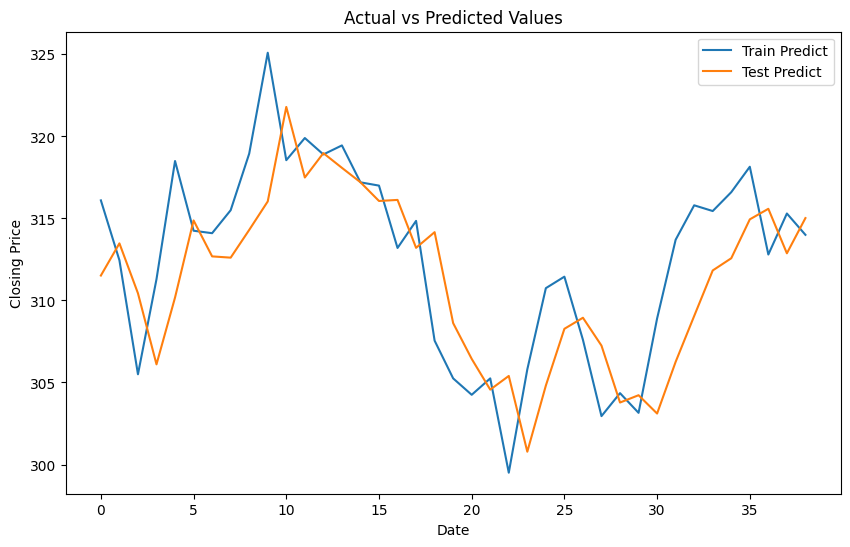

In [37]:
plt.figure(figsize=(10, 6))
# plt.plot(scaler.inverse_transform(scaled_data), label='Actual')
plt.plot(y_test_scaled, label='Train Predict')
plt.plot(y_pred, label='Test Predict')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

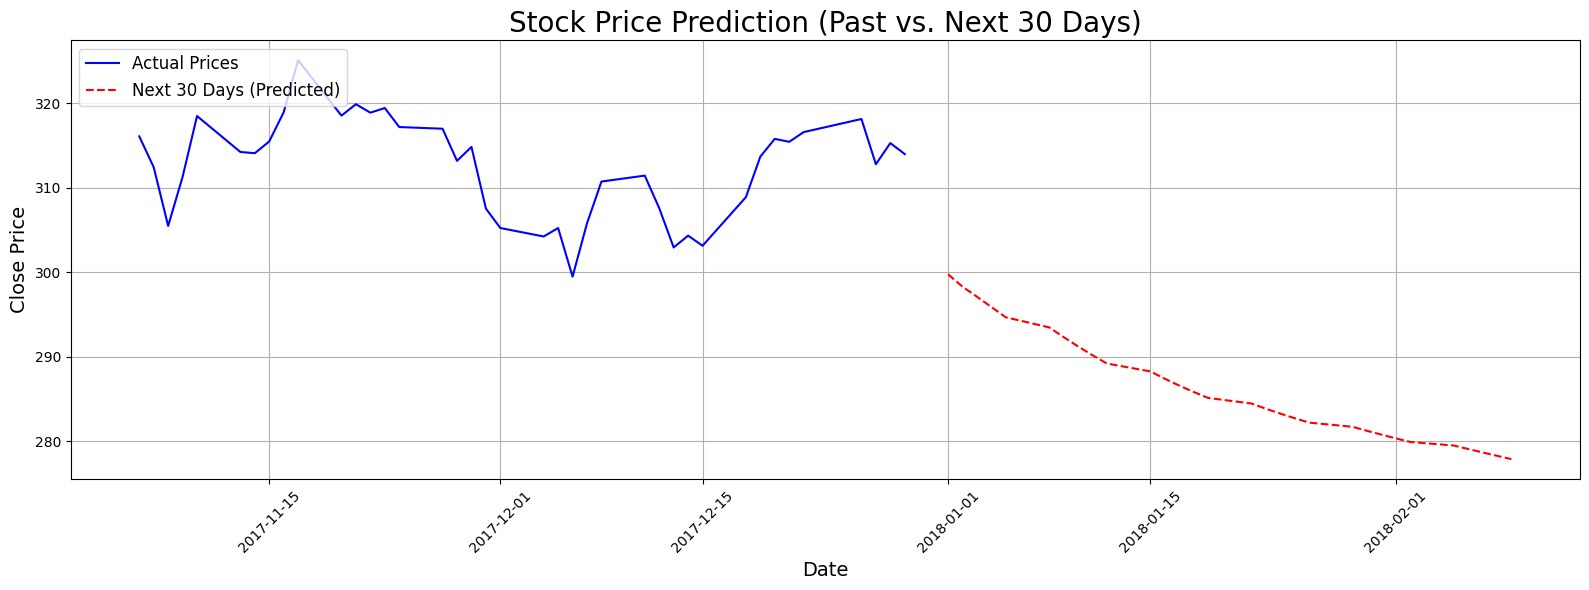

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Predict the next 30 days of stock prices based on the last 60 days of training data
last_60_days = train_data[-60:]  # Use the last 60 days from training data
input_data = np.array(last_60_days).reshape(1, 60, 5)  # Reshape to (1, 60, 5) because training data has 5 features

# Predict the next 30 days (future predictions)
future_predictions = []

for day in range(30):
    next_day_price = model.predict(input_data)[0, 0]  # Predict the next day's price (closing price)
    future_predictions.append(next_day_price)

    # Update the input_data for the next prediction
    next_day_price_reshaped = np.repeat(next_day_price.reshape(1, 1, 1), 5, axis=2)  # Repeat for all 5 features

    # Update the input_data with the predicted value (adding new prediction for the next day's feature)
    input_data = np.concatenate([input_data[:, 1:, :], next_day_price_reshaped], axis=1)

# Convert future predictions back to the original scale
future_predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(future_predictions), X_train.shape[2] - 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, -1]

# Step 2: Prepare the data for plotting (combine past data and future predictions)
# Create the time range for the next 30 days
future_dates = pd.date_range(start=company_df['TIMESTAMP'].iloc[-1] + pd.Timedelta(days=1), periods=30, freq='B')

# Plotting the actual and predicted data (past and future)
plt.figure(figsize=(16, 6))
plt.title('Stock Price Prediction (Past vs. Next 30 Days)', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)

# Plot the past closing prices (from training data)
plt.plot(company_df['TIMESTAMP'][-len(y_test_scaled):], y_test_scaled, label='Actual Prices', color='blue')

# Plot the predicted closing prices for the next 30 days
plt.plot(future_dates, future_predictions, label='Next 30 Days (Predicted)', color='red', linestyle='--')

# Add a legend and grid
plt.legend(loc='upper left', fontsize=12)
plt.grid()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
